In [6]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_

In [19]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from torchsummary import summary
import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [8]:
data_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")
data_df.head(5)

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [9]:
data_df.dropna(inplace=True)
data_df.drop(['id'], axis=1, inplace=True)

In [10]:
data_df.shape

(18185, 11)

In [11]:
original_df = data_df.copy()

for column in data_df.columns:
  data_df[column] = data_df[column]/ data_df[column].abs().max()

data_df

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0
...,...,...,...,...,...,...,...,...,...,...,...
18180,0.573262,0.811219,0.618156,0.971489,0.545785,0.757140,0.562384,0.654774,0.733291,0.744543,0.0
18181,0.742899,0.925674,0.704314,0.971683,0.709121,0.861916,0.730296,0.758107,0.708884,0.745661,0.0
18182,0.623408,0.844800,0.640916,0.972058,0.593296,0.789562,0.633098,0.673049,0.754720,0.747830,0.0
18183,0.583741,0.826356,0.623551,0.972748,0.562227,0.764030,0.555396,0.675248,0.702103,0.751874,0.0


In [12]:
X = np.array(data_df.iloc[:, :-1])
Y = np.array(data_df.iloc[:, -1])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split( X_test, y_test, test_size= 0.5)

print("Training set is: ", X_train.shape[0], " rows which is ", round(X_train.shape[0]/data_df.shape[0],4)*100, "%") # Print training shape
print("Validation set is: ",X_val.shape[0], " rows which is ", round(X_val.shape[0]/data_df.shape[0],4)*100, "%") # Print validation shape
print("Testing set is: ",X_test.shape[0], " rows which is ", round(X_test.shape[0]/data_df.shape[0],4)*100, "%") # Print testing shape


Training set is:  12729  rows which is  70.0 %
Validation set is:  2728  rows which is  15.0 %
Testing set is:  2728  rows which is  15.0 %


In [13]:
class dataset(Dataset):
  def __init__(self, X, Y):
    self.X = torch.tensor(X, dtype= torch.float32).to(device)
    self.Y = torch.tensor(Y, dtype =torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.Y[index]


In [15]:
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
test_data = dataset(X_test, y_test)

In [16]:
training_dataloader = DataLoader(training_data, batch_size=8, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=True)

In [18]:
HIDDEN_NEURONS = 10

class MyModel(nn.Module):
  def __init__(self):

    super(MyModel, self).__init__()

    self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
    self.linear =  nn.Linear(HIDDEN_NEURONS, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self,x):
    x=self.input_layer(x)
    x=self.linear(x)
    x=self.sigmoid(x)
    return x


model=MyModel().to(device)

In [20]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [21]:
BATCH_SIZE = 32
EPOCHS = 10
HIDDEN_NEURONS = 10
LR = 1e-3

In [22]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=LR)

In [30]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for data in training_dataloader:
      inputs, labels = data
      prediction = model(inputs).squeeze(1)
      batch_loss = criterion(prediction, labels)
      total_loss_train += batch_loss.item()
      train_acc = ((prediction).round() == labels).sum().item()
      total_acc_train += train_acc

      batch_loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    with torch.no_grad():
      for data in validation_dataloader:
        inputs, labels = data
        prediction= model(inputs).squeeze(1)
        batch_loss = criterion(prediction, labels)
        total_loss_val += batch_loss.item()
        val_acc = ((prediction).round() ==labels).sum().item()
        total_acc_val += val_acc

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/(training_data.__len__())*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/(validation_data.__len__())*100, 4))


    print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(training_data.__len__())*100):.4f} Validation Loss: {total_loss_val/1000:.4f} Validation Accuracy: {(total_acc_val/(validation_data.__len__())*100):.4f}''')
    print("="*50)

Epoch no. 1 Train Loss: 0.0718 Train Accuracy: 98.6409 Validation Loss: 0.0156 Validation Accuracy: 98.6070
Epoch no. 2 Train Loss: 0.0674 Train Accuracy: 98.6802 Validation Loss: 0.0153 Validation Accuracy: 98.4604
Epoch no. 3 Train Loss: 0.0649 Train Accuracy: 98.6645 Validation Loss: 0.0169 Validation Accuracy: 98.3871
Epoch no. 4 Train Loss: 0.0648 Train Accuracy: 98.6330 Validation Loss: 0.0157 Validation Accuracy: 98.6070
Epoch no. 5 Train Loss: 0.0638 Train Accuracy: 98.6488 Validation Loss: 0.0156 Validation Accuracy: 98.6070
Epoch no. 6 Train Loss: 0.0627 Train Accuracy: 98.6645 Validation Loss: 0.0151 Validation Accuracy: 98.6070
Epoch no. 7 Train Loss: 0.0636 Train Accuracy: 98.7116 Validation Loss: 0.0152 Validation Accuracy: 98.6070
Epoch no. 8 Train Loss: 0.0631 Train Accuracy: 98.6330 Validation Loss: 0.0155 Validation Accuracy: 98.6070
Epoch no. 9 Train Loss: 0.0626 Train Accuracy: 98.7116 Validation Loss: 0.0159 Validation Accuracy: 98.4971
Epoch no. 10 Train Loss: 0.0

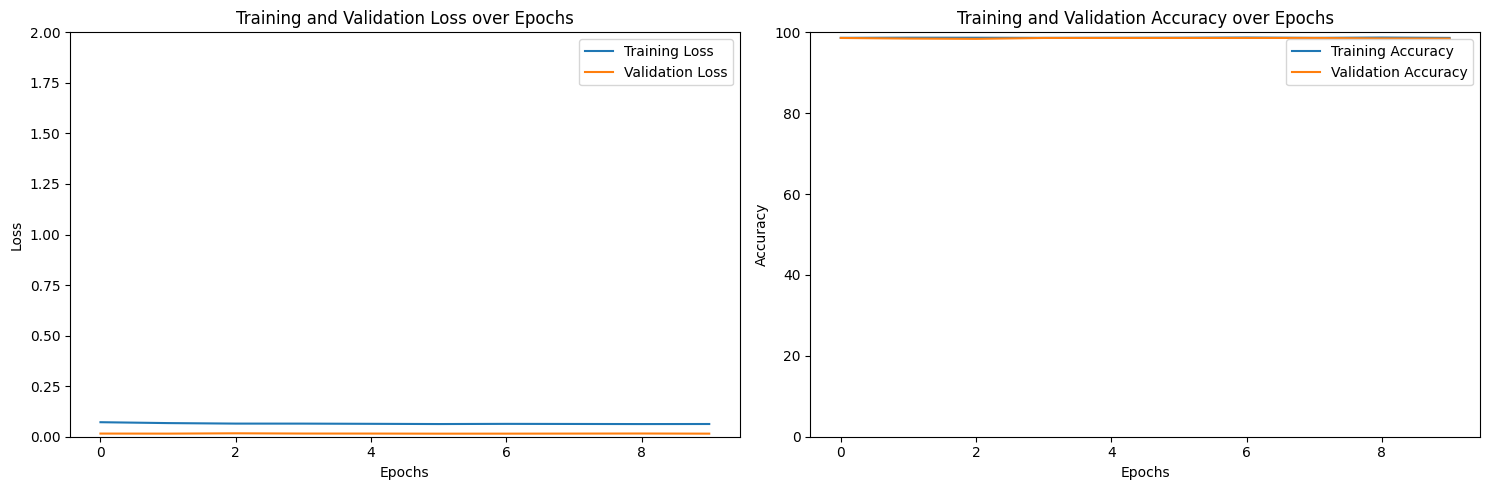

In [31]:


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

In [32]:

area = float(input("Area: "))/original_df['Area'].abs().max()
MajorAxisLength = float(input("Major Axis Length: "))/original_df['MajorAxisLength'].abs().max()
MinorAxisLength = float(input("Minor Axis Length: "))/original_df['MinorAxisLength'].abs().max()
Eccentricity = float(input("Eccentricity: "))/original_df['Eccentricity'].abs().max()
ConvexArea = float(input("Convex Area: "))/original_df['ConvexArea'].abs().max()
EquivDiameter = float(input("EquivDiameter: "))/original_df['EquivDiameter'].abs().max()
Extent = float(input("Extent: "))/original_df['Extent'].abs().max()
Perimeter = float(input("Perimeter: "))/original_df['Perimeter'].abs().max()
Roundness = float(input("Roundness: "))/original_df['Roundness'].abs().max()
AspectRation = float(input("AspectRation: "))/original_df['AspectRation'].abs().max()

my_inputs = [area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation]

print("="*20)
model_inputs = torch.Tensor(my_inputs).to(device)
prediction = (model(model_inputs))
print(prediction)
print("Class is: ", round(prediction.item()))


Area: 6431.279


KeyboardInterrupt: Interrupted by user